In [2]:
import random
from geoarray import GeoArray
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.signal import savgol_filter
from scipy.interpolate import splev, splrep
# importing ISOFIT
from isofit.utils import surface_model
from isofit.core.forward import ForwardModel
from isofit.configs.configs import create_new_config
from isofit.inversion.inverse import Inversion
from isofit.core.fileio import IO
import tkinter
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [3]:
cluster = np.loadtxt(r'C:\Users\vpatro\Desktop\Final_Spectra\425\Cl_6.txt')

In [5]:
cluster.shape

(412437, 425)

(0.0, 0.65)

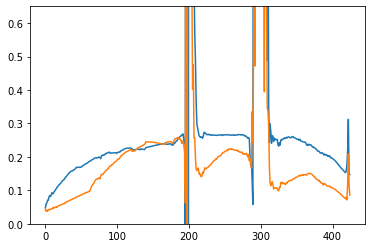

In [4]:
cluster[:, 105:120] = savgol_filter(cluster[:, 105:120], 11,1, axis = 1)
cluster[:, 140:165] = savgol_filter(cluster[:, 140:165], 21, 1, axis = 1)
cluster[:, 398:419] = savgol_filter(cluster[:, 398:419], 11, 1, axis = 1)
plt.plot(cluster[100000])
plt.plot(cluster[200000])
plt.ylim(0,0.65)

(0.0, 0.4)

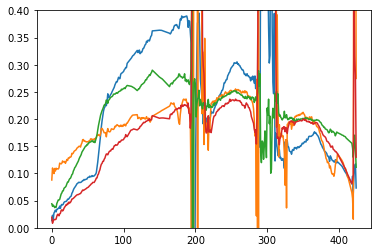

In [7]:
plt.plot(cluster[150000])
plt.plot(cluster[250000])
plt.plot(cluster[300000])
plt.plot(cluster[400000])
plt.ylim(0,0.4)

In [8]:
def sample_spectra(cluster_spectra:np.array, num_sets, num_samples):

    sample_sets = []
    
    for i in range(num_sets):
        sample = random.sample(range(0, cluster_spectra.shape[0]), num_samples)
        sample_sets.append(cluster_spectra[sample])
        
    sample_sets = np.array(sample_sets)
        
    return sample_sets

def add_RT_parameters(multi_set_spectra:np.array)-> np.array:
    
    augmented_set = []
    
    H2O = [1.75] * multi_set_spectra.shape[1]
    AOT = [0.05] * multi_set_spectra.shape[1]
    
    H2O = np.array(H2O)[:,None]
    AOT = np.array(AOT)[:,None]
    
    for i in range(multi_set_spectra.shape[0]):
        augmented = np.concatenate((multi_set_spectra[i], AOT), axis = 1)
        augmented = np.concatenate((augmented, H2O), axis = 1)
        augmented_set.append(augmented)
        
    augmented_set = np.array(augmented_set)
    
    return augmented_set

def run_ISOFIT(input_reflectance: np.array) -> np.array:
    
    # Surface model
    surface_model("C:\\Users\\vpatro\\Desktop\\isofit_vp\\examples\\20171108_Pasadena\\configs\\ang20171108t184227_surface.json")

    # Creating ISOFIT objects
    config = create_new_config("C:\\Users\\vpatro\\Desktop\\isofit_vp\\examples\\20171108_Pasadena\\configs\\ang20171108t184227_beckmanlawn.json")
    fm = ForwardModel(config)
    inv = Inversion(config, fm)
    io = IO(config, fm)
    io.get_components_at_index(0, 0)
    geom = io.current_input_data.geom # alternately, call via geom = Geometry()...this won't have data from the above config file
    meas = io.current_input_data.meas  # a numpy  array

    # adding in Radiative Transfer Parameters
    #x = np.loadtxt("C:\\Users\\vpatro\\Desktop\\avirisng_input.txt")
    input_reflectance = np.append(input_reflectance,0.05)
    input_reflectance = np.append(input_reflectance,1.75)
    
    radiance_measurement = fm.calc_rdn(input_reflectance,geom)
    OE_estimation = inv.invert(radiance_measurement, geom)[-1]
    
    return OE_estimation

In [9]:
def remove_bad_bands(spectra: np.array):
    bands = list(range(0,425))
    bands = np.array(bands)
    deeph2o = np.logical_or(np.logical_and(bands > 181, bands < 224), np.logical_and(bands > 275, bands < 329))
    bad_cal = np.logical_or(bands > 418, bands < 3)
    bad = np.logical_or(deeph2o, bad_cal)
    spectra[bad] = np.nan
    
    return spectra

In [10]:
# Appending RT parameters
sample_sets = sample_spectra(cluster, 5, 100)
print(sample_sets.shape)
augmented_sets = add_RT_parameters(sample_sets)
print(augmented_sets.shape)

(5, 100, 425)
(5, 100, 427)


In [11]:
l2norms = []
residuals = []
inputs = []
outputs = []

In [13]:
for i in range(100):
    input_vec = augmented_sets[0][i].copy()
    inputs.append(input_vec)
    OE_estimation = run_ISOFIT(input_vec)
    outputs.append(OE_estimation)
    l2norm = np.linalg.norm(input_vec - OE_estimation)
    l2norms.append(l2norm)
    residual = input_vec-OE_estimation
    residuals.append(residual)


In [14]:
for i in range(100):
    input_vec = augmented_sets[1][i].copy()
    inputs.append(input_vec)
    OE_estimation = run_ISOFIT(input_vec)
    outputs.append(OE_estimation)
    l2norm = np.linalg.norm(input_vec - OE_estimation)
    l2norms.append(l2norm)
    residual = input_vec-OE_estimation
    residuals.append(residual)


In [15]:
for i in range(100):
    input_vec = augmented_sets[2][i].copy()
    inputs.append(input_vec)
    OE_estimation = run_ISOFIT(input_vec)
    outputs.append(OE_estimation)
    l2norm = np.linalg.norm(input_vec - OE_estimation)
    l2norms.append(l2norm)
    residual = input_vec-OE_estimation
    residuals.append(residual)


In [16]:
for i in range(100):
    input_vec = augmented_sets[3][i].copy()
    inputs.append(input_vec)
    OE_estimation = run_ISOFIT(input_vec)
    outputs.append(OE_estimation)
    l2norm = np.linalg.norm(input_vec - OE_estimation)
    l2norms.append(l2norm)
    residual = input_vec-OE_estimation
    residuals.append(residual)


In [17]:
for i in range(100):
    input_vec = augmented_sets[4][i].copy()
    inputs.append(input_vec)
    OE_estimation = run_ISOFIT(input_vec)
    outputs.append(OE_estimation)
    l2norm = np.linalg.norm(input_vec - OE_estimation)
    l2norms.append(l2norm)
    residual = input_vec-OE_estimation
    residuals.append(residual)


In [19]:
inputs = np.array(inputs)
outputs = np.array(outputs)

In [64]:
x = np.linspace(375, 2500, 425)

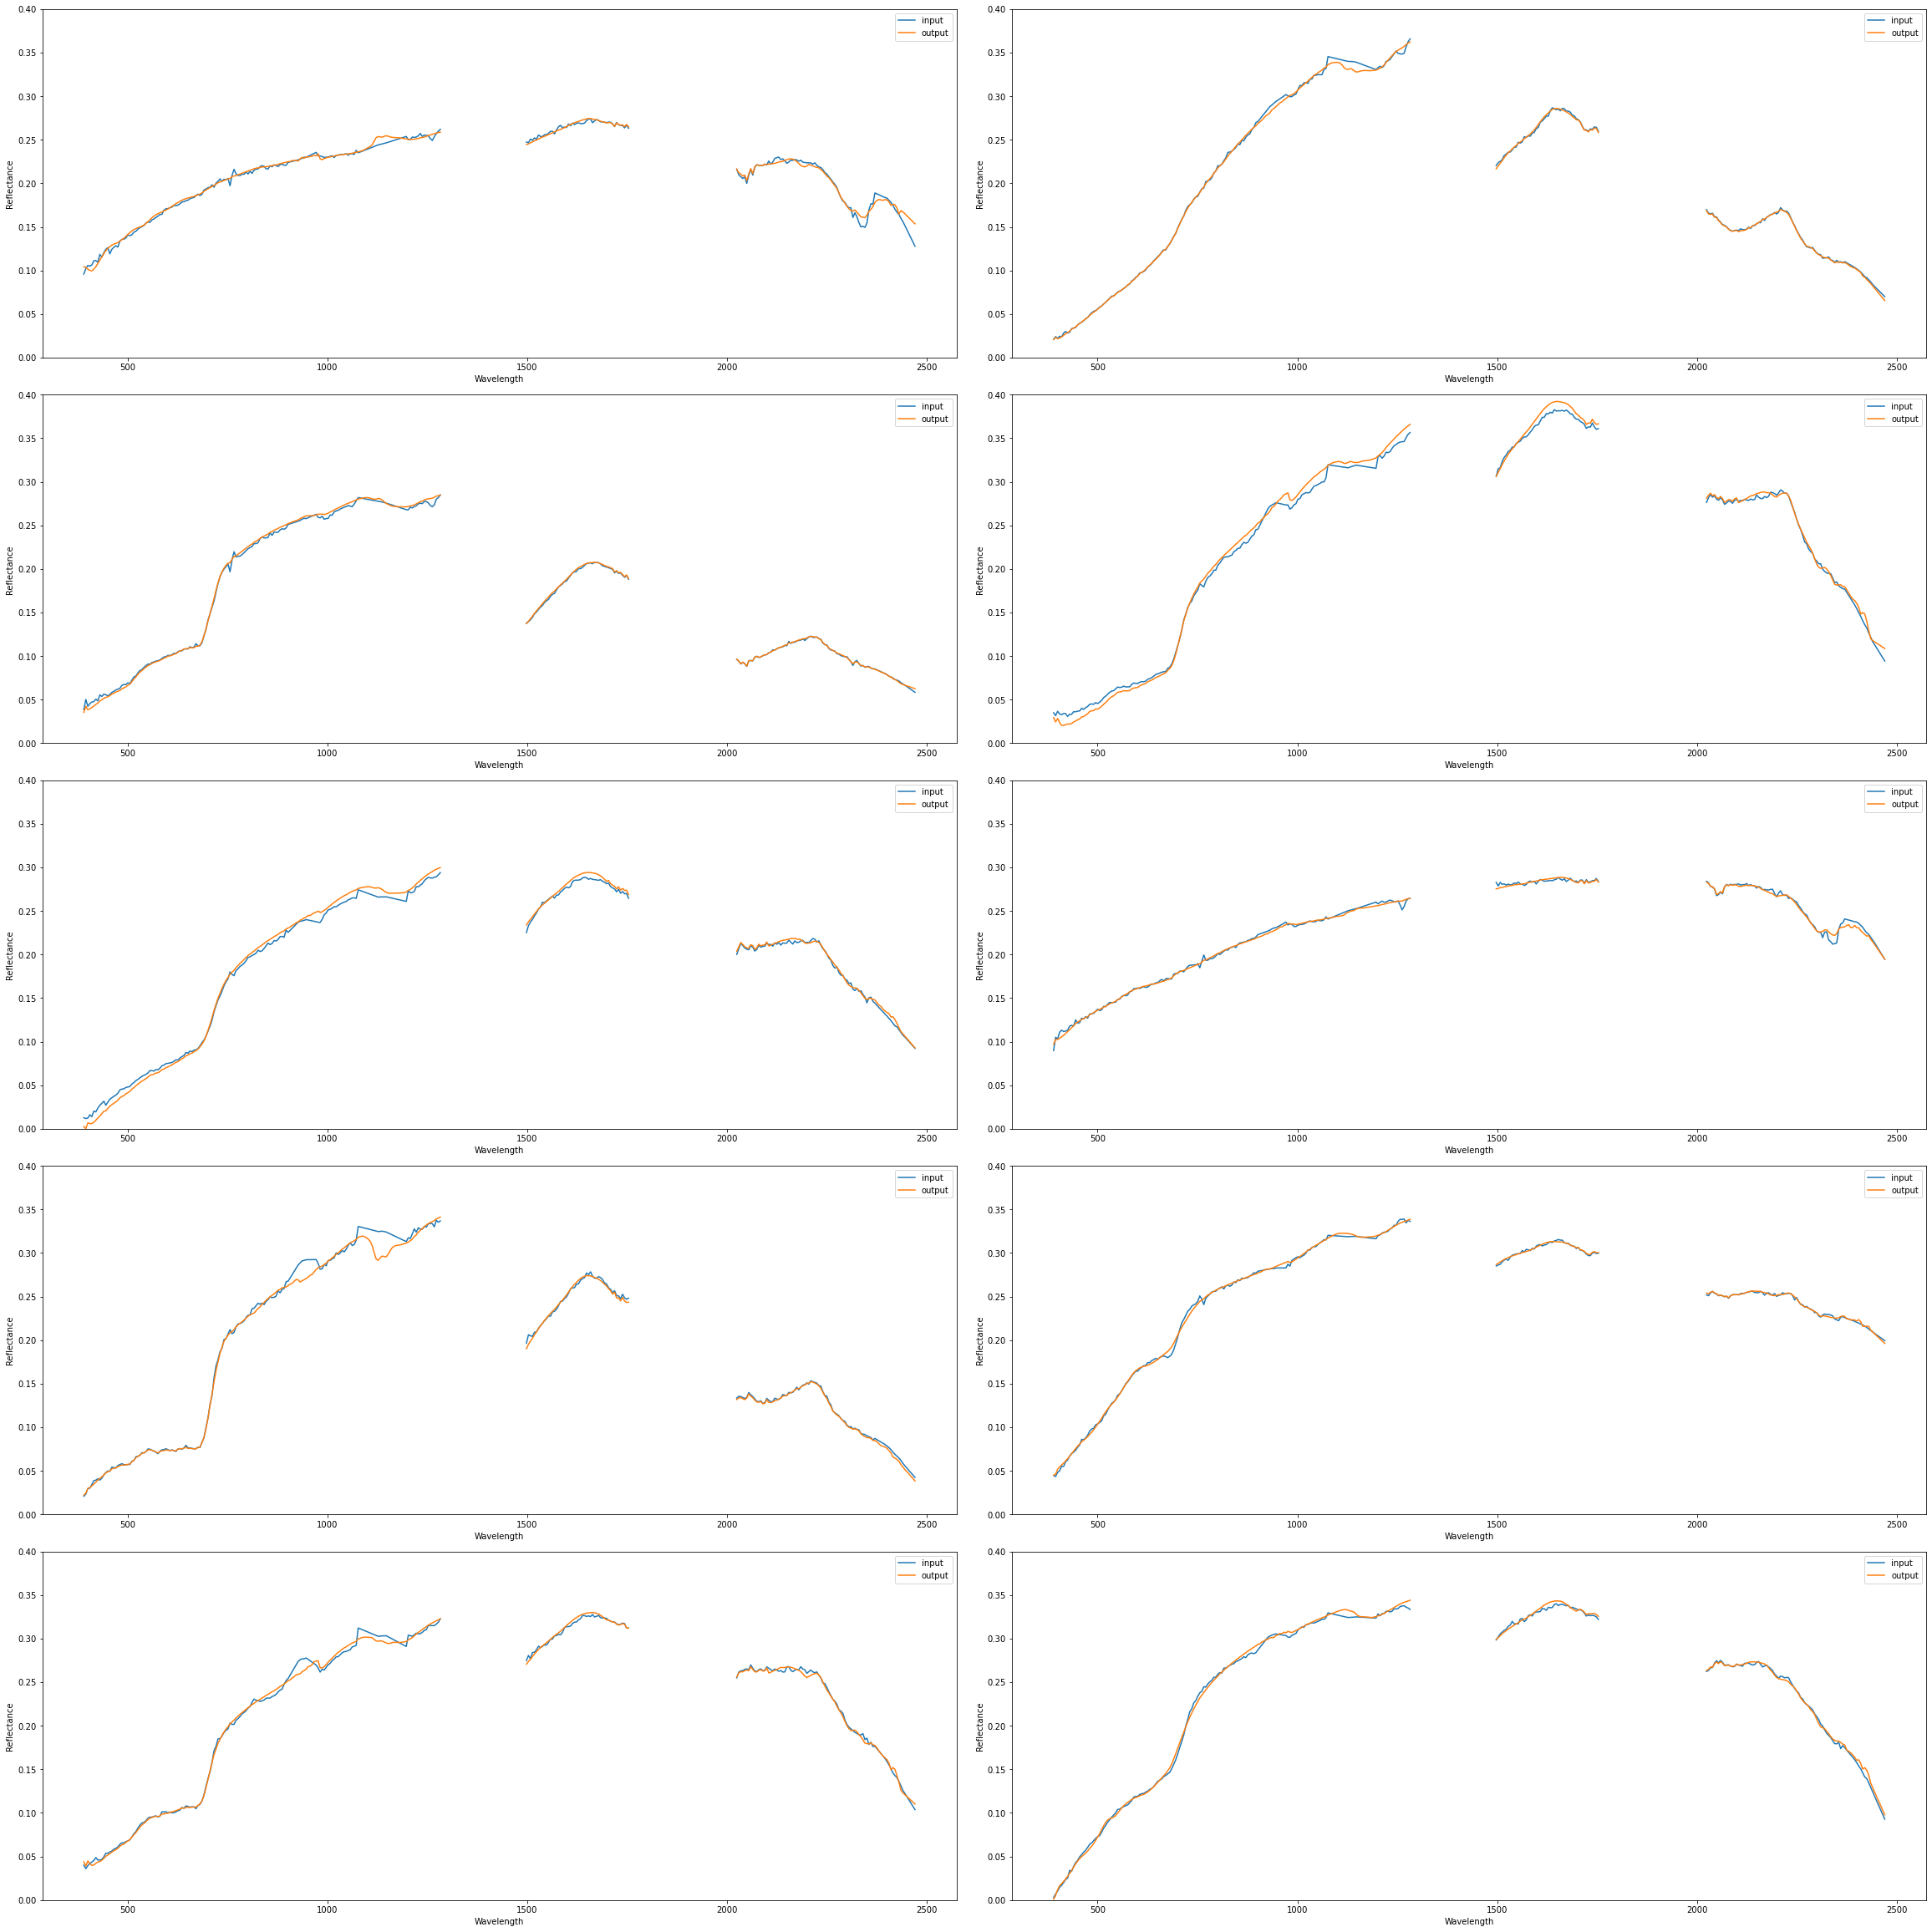

In [65]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (32,32), constrained_layout = True)

count = 0
row = 0
col = 0
for i in range(0,100,10):
    if col == 2:
        row +=1
        col = 0
    cleaned_input = remove_bad_bands(inputs[i,:425].copy())
    cleaned_output = remove_bad_bands(outputs[i][:425].copy())
    axs[row,col].plot(x,cleaned_input, label = 'input')
    axs[row,col].plot(x,cleaned_output, label = 'output')
    axs[row,col].legend()
    axs[row,col].set_ylim(0,0.4)
    axs[row,col].set_xlabel('Wavelength')
    axs[row,col].set_ylabel('Reflectance')
    col+= 1

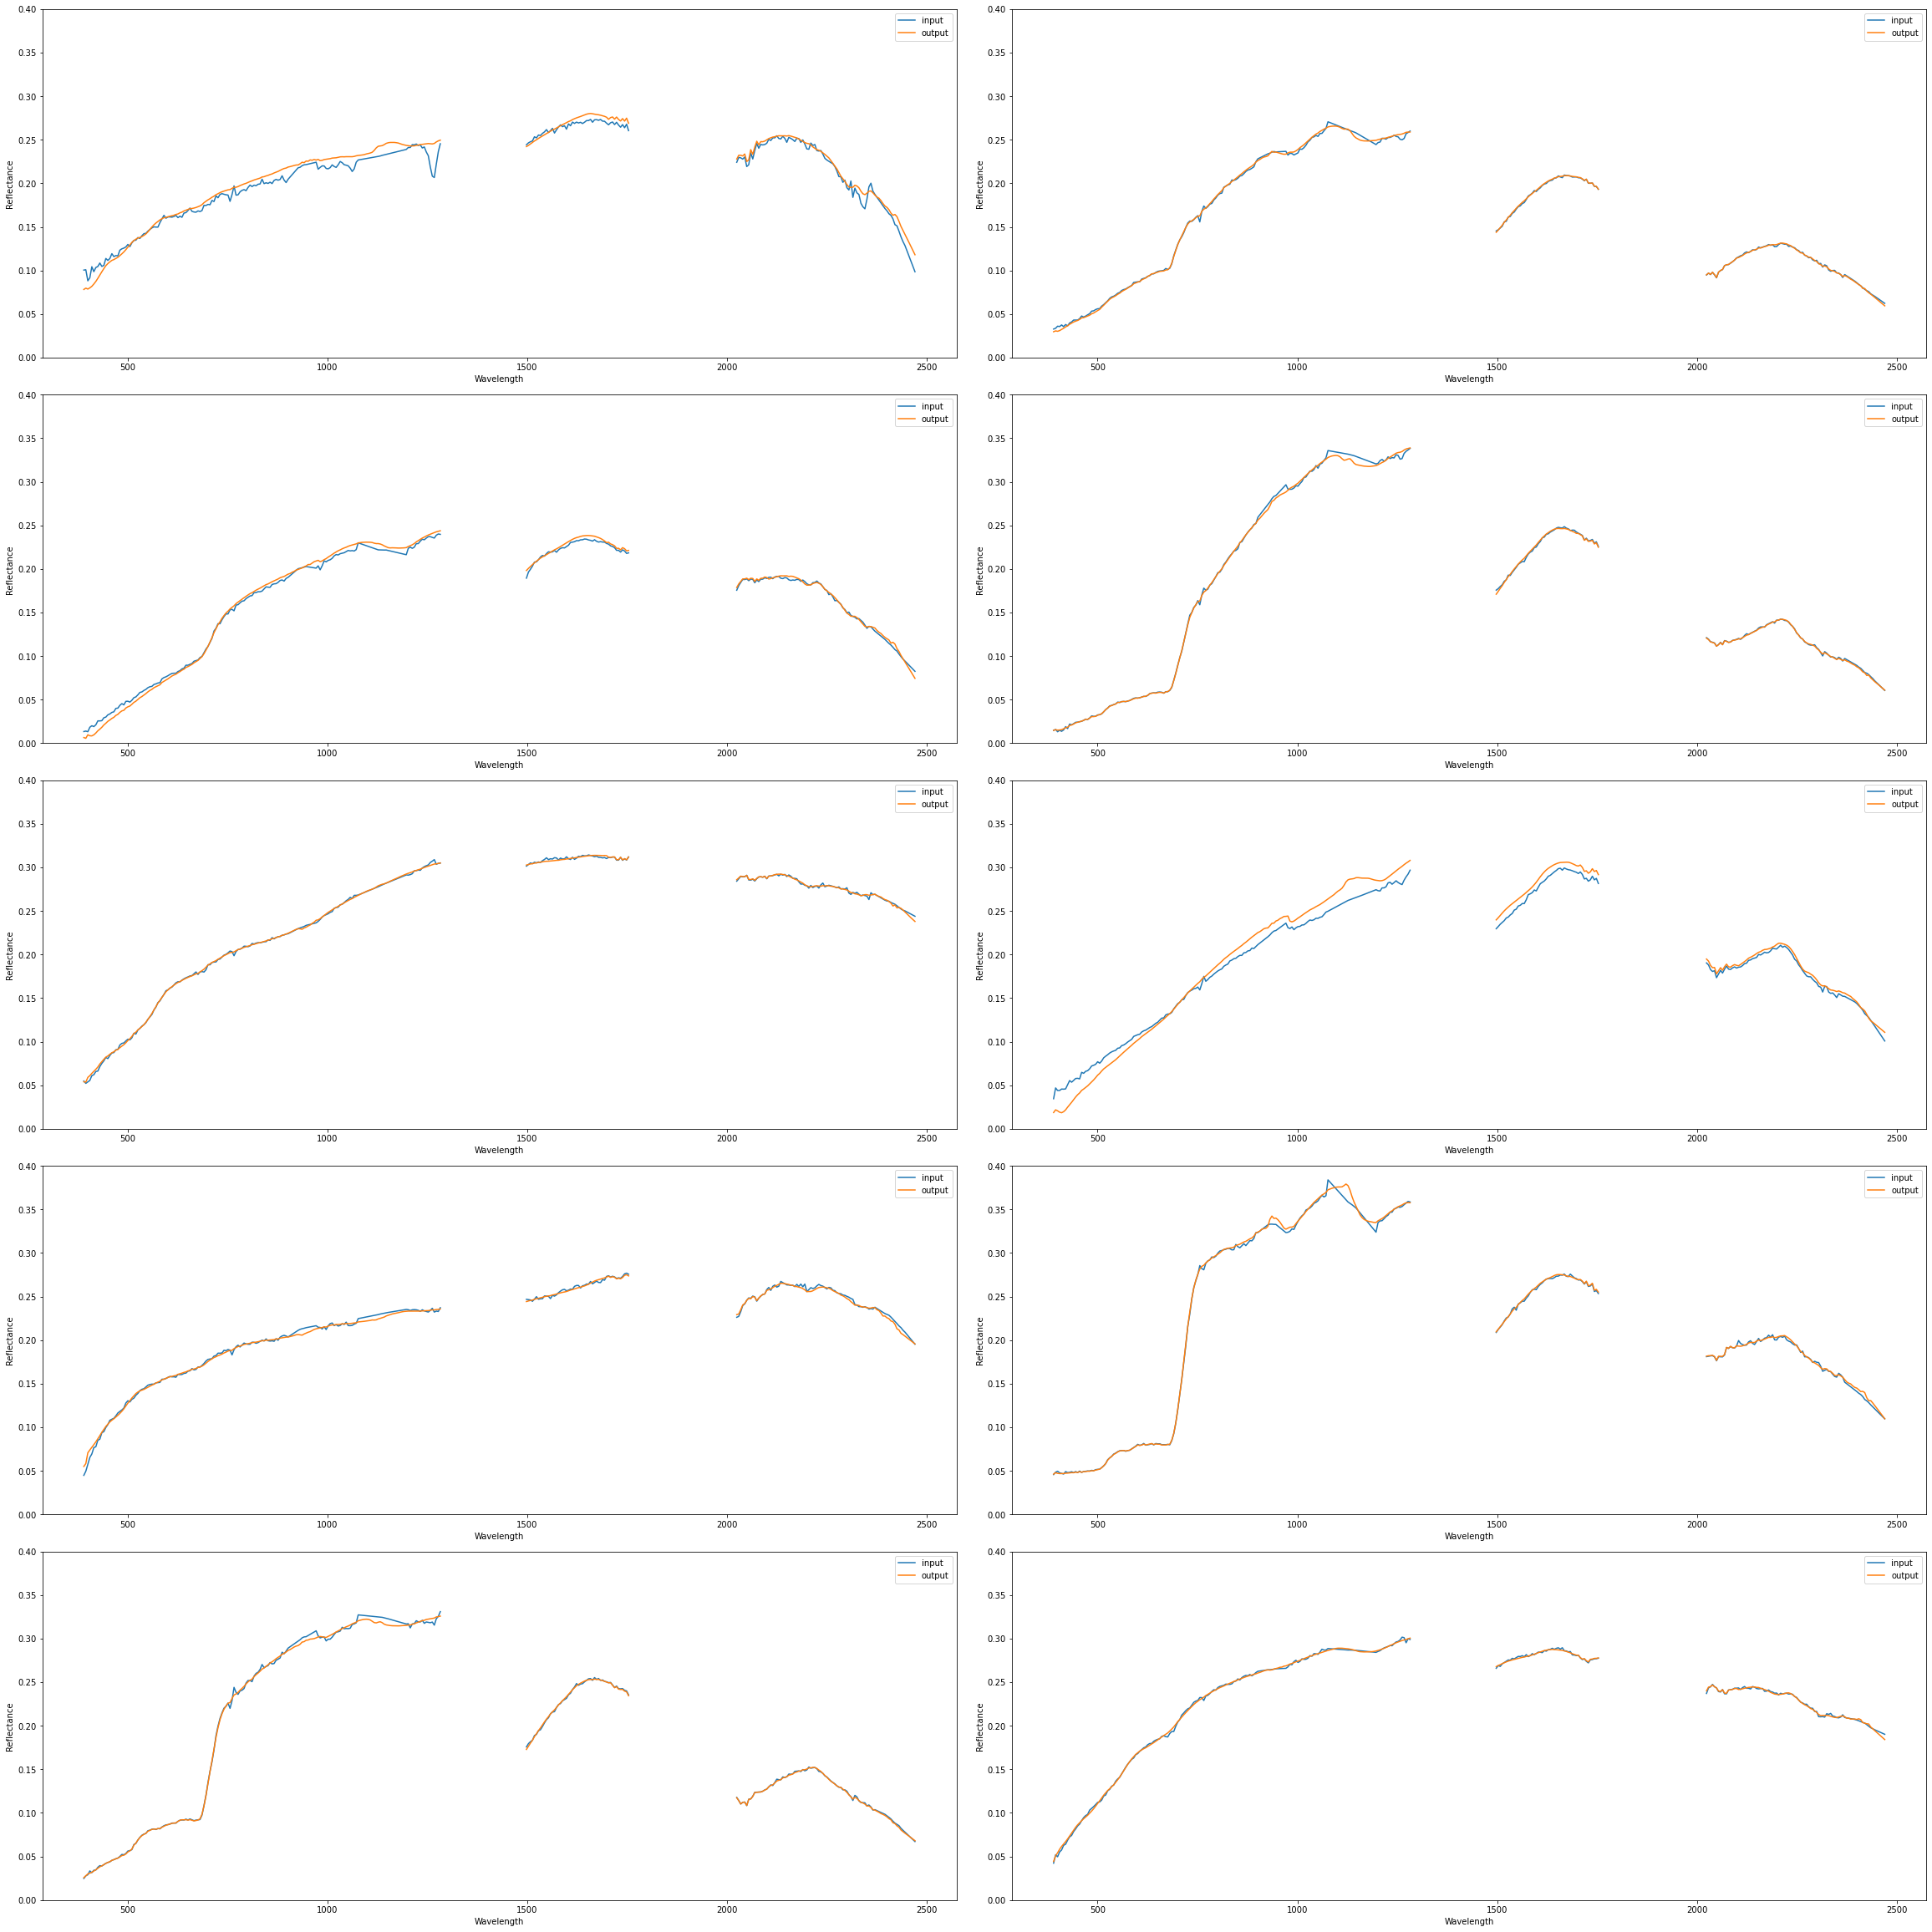

In [66]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (32,32), constrained_layout = True)

count = 0
row = 0
col = 0
for i in range(100,200,10):
    if col == 2:
        row +=1
        col = 0
    cleaned_input = remove_bad_bands(inputs[i,:425].copy())
    cleaned_output = remove_bad_bands(outputs[i][:425].copy())
    axs[row,col].plot(x,cleaned_input, label = 'input')
    axs[row,col].plot(x,cleaned_output, label = 'output')
    axs[row,col].legend()
    axs[row,col].set_ylim(0,0.4)
    axs[row,col].set_xlabel('Wavelength')
    axs[row,col].set_ylabel('Reflectance')
    col+= 1

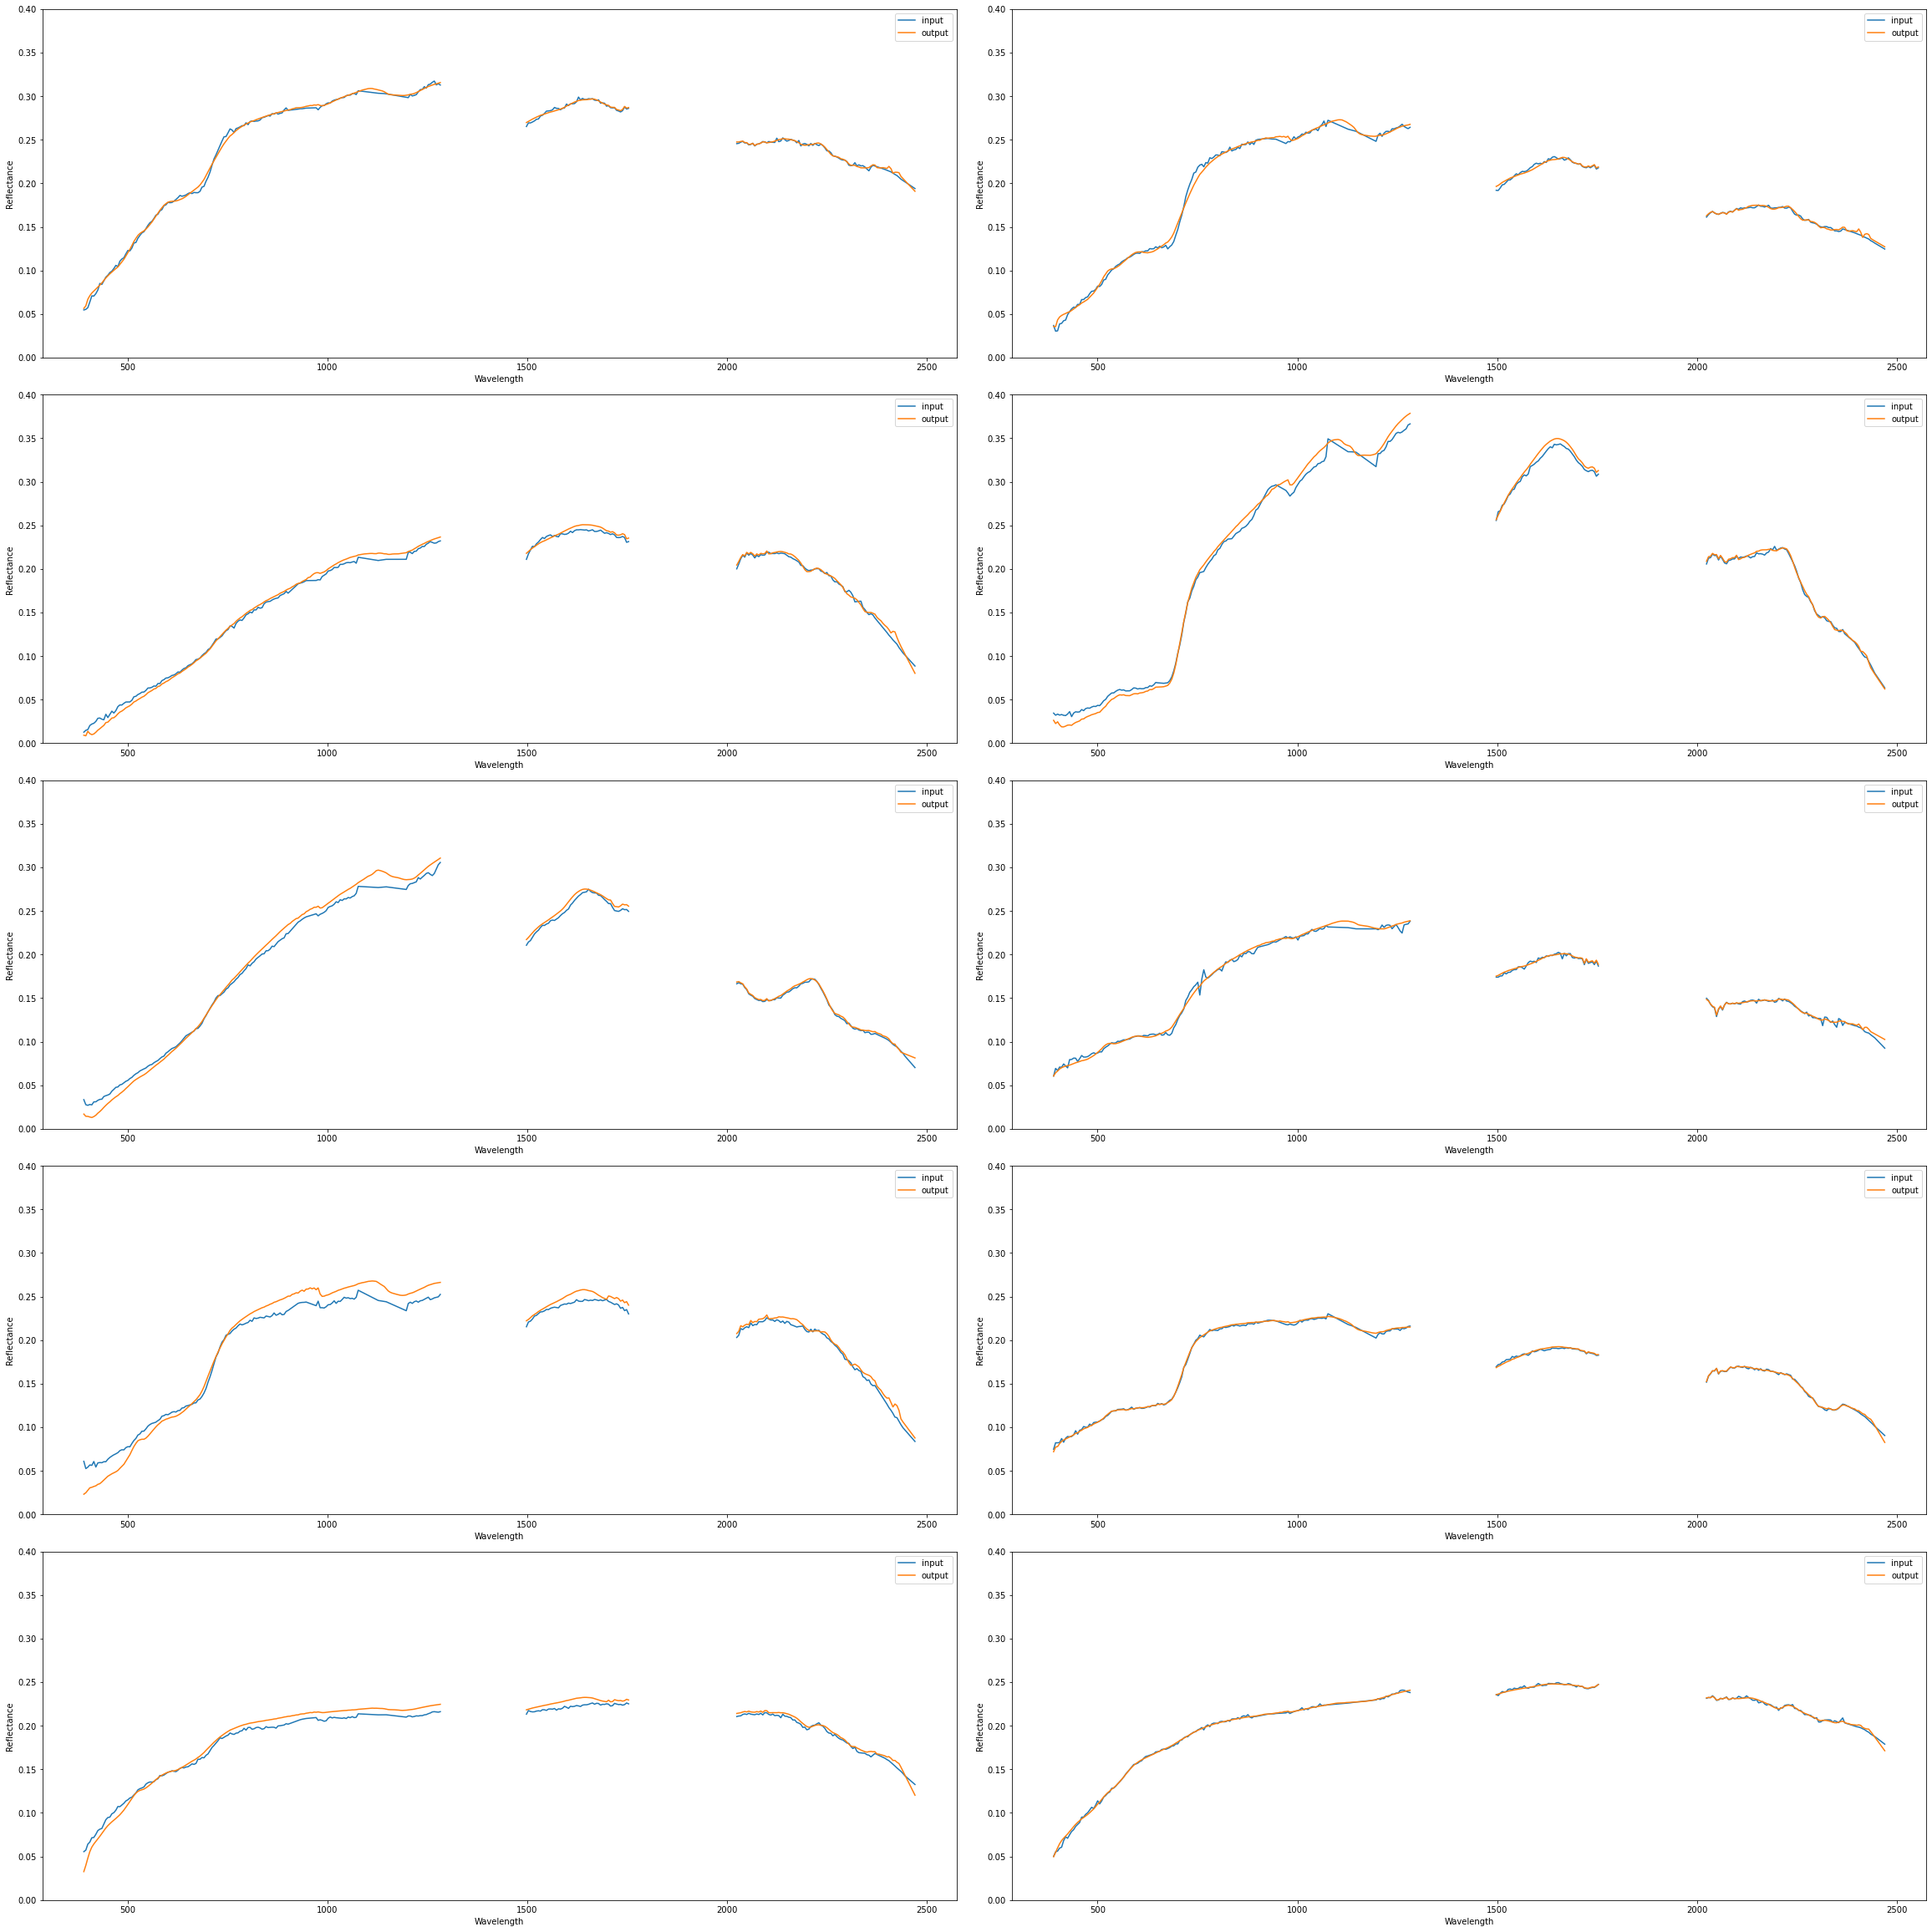

In [67]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (32,32), constrained_layout = True)

count = 0
row = 0
col = 0
for i in range(200,300,10):
    if col == 2:
        row +=1
        col = 0
    cleaned_input = remove_bad_bands(inputs[i,:425].copy())
    cleaned_output = remove_bad_bands(outputs[i][:425].copy())
    axs[row,col].plot(x,cleaned_input, label = 'input')
    axs[row,col].plot(x,cleaned_output, label = 'output')
    axs[row,col].legend()
    axs[row,col].set_ylim(0,0.4)
    axs[row,col].set_xlabel('Wavelength')
    axs[row,col].set_ylabel('Reflectance')
    col+= 1

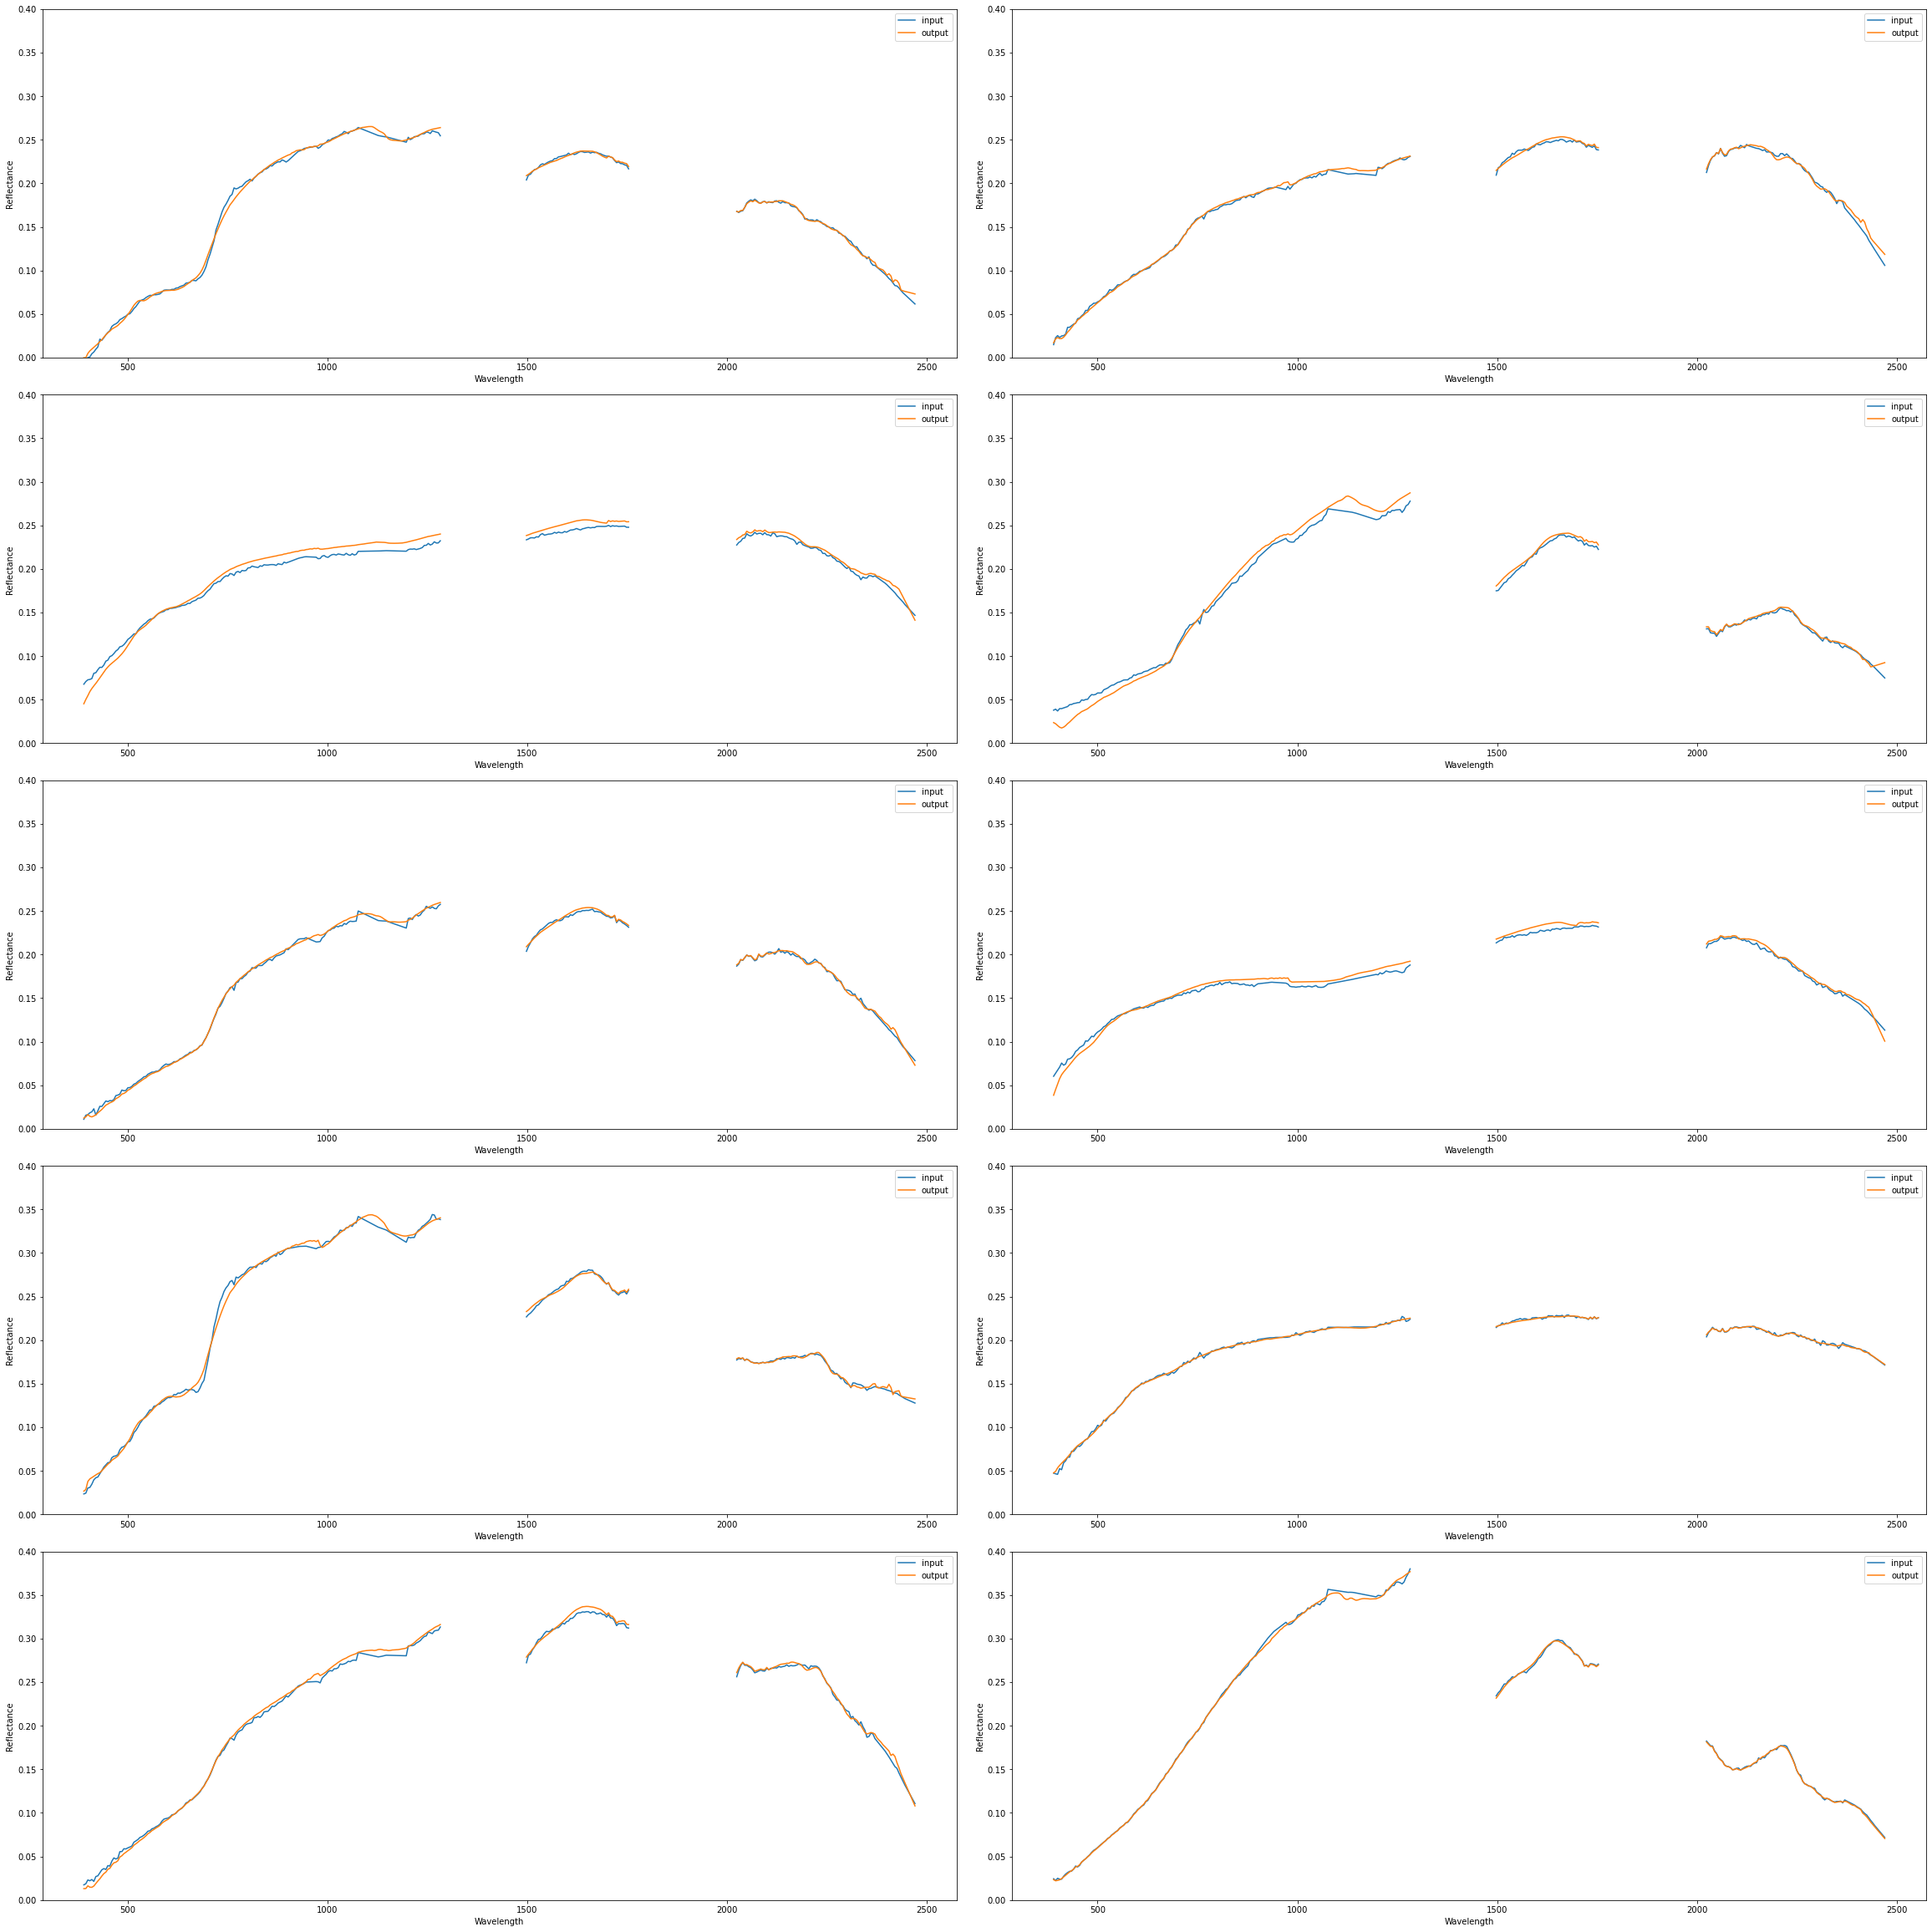

In [68]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (32,32), constrained_layout = True)

count = 0
row = 0
col = 0
for i in range(300,400,10):
    if col == 2:
        row +=1
        col = 0
    cleaned_input = remove_bad_bands(inputs[i,:425].copy())
    cleaned_output = remove_bad_bands(outputs[i][:425].copy())
    axs[row,col].plot(x,cleaned_input, label = 'input')
    axs[row,col].plot(x,cleaned_output, label = 'output')
    axs[row,col].legend()
    axs[row,col].set_ylim(0,0.4)
    axs[row,col].set_xlabel('Wavelength')
    axs[row,col].set_ylabel('Reflectance')
    col+= 1

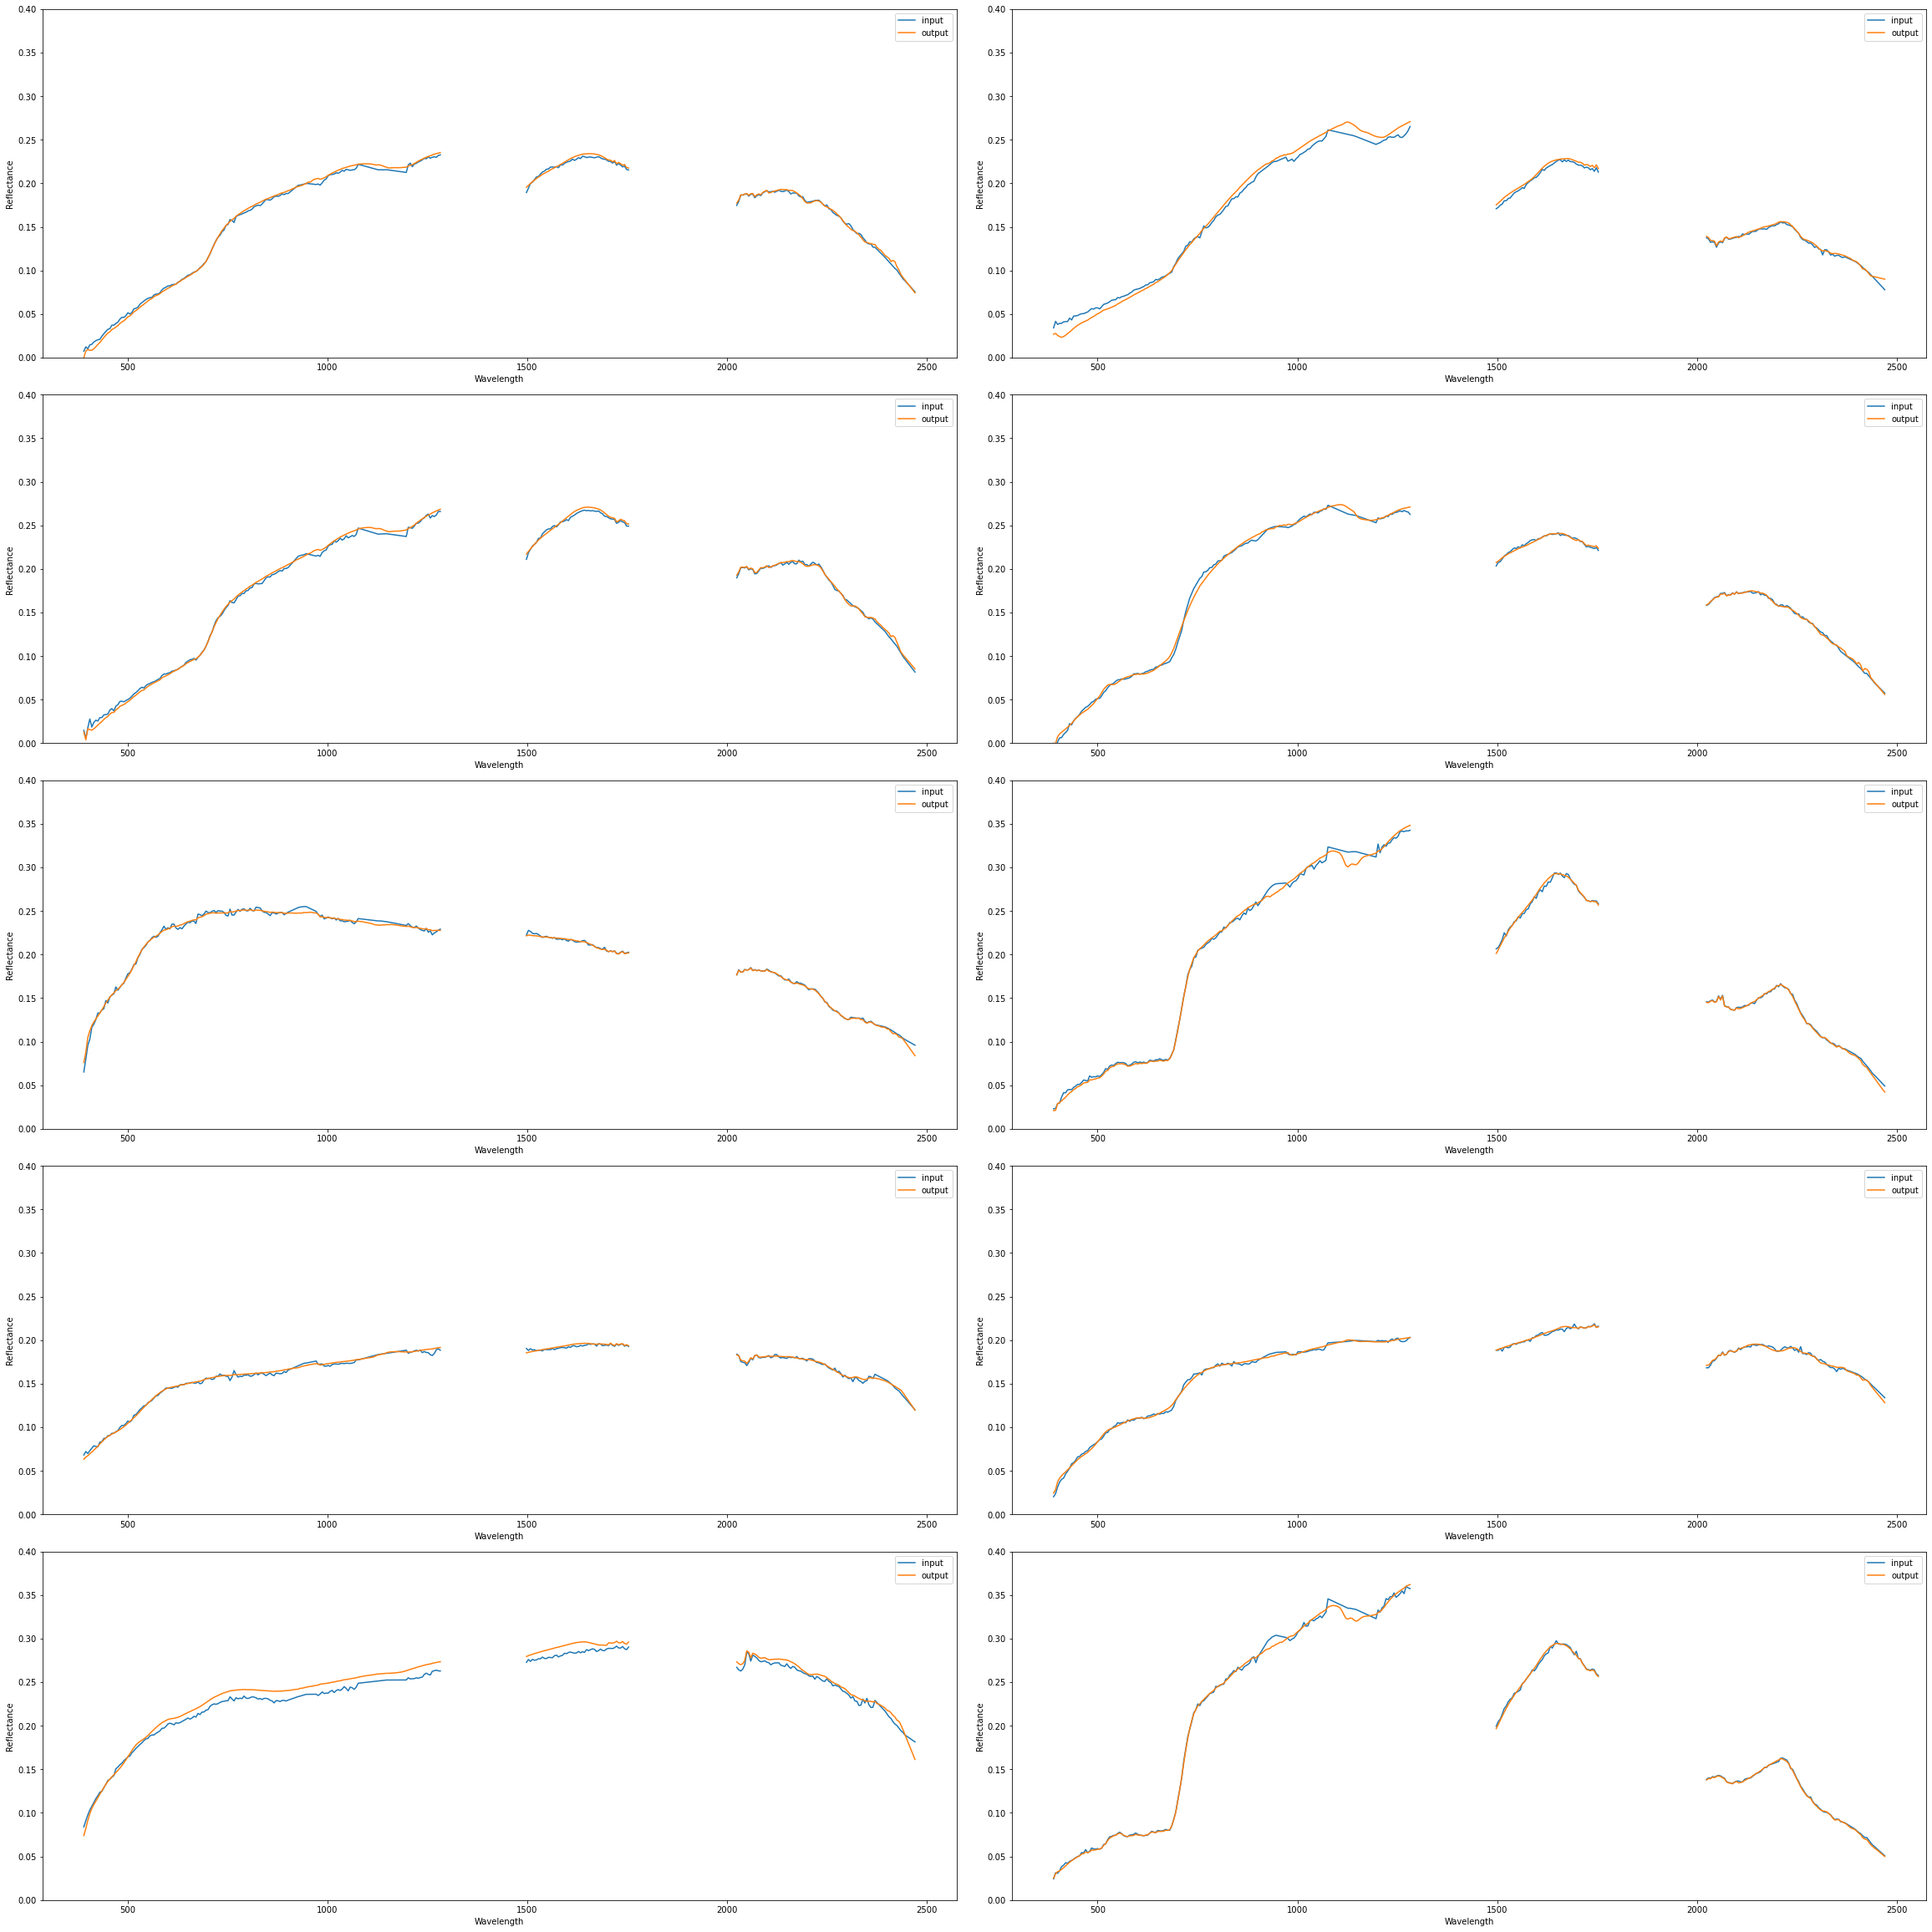

In [69]:
fig, axs = plt.subplots(nrows = 5, ncols = 2, figsize = (32,32), constrained_layout = True)

count = 0
row = 0
col = 0
for i in range(400,500,10):
    if col == 2:
        row +=1
        col = 0
    cleaned_input = remove_bad_bands(inputs[i,:425].copy())
    cleaned_output = remove_bad_bands(outputs[i][:425].copy())
    axs[row,col].plot(x,cleaned_input, label = 'input')
    axs[row,col].plot(x,cleaned_output, label = 'output')
    axs[row,col].legend()
    axs[row,col].set_ylim(0,0.4)
    axs[row,col].set_xlabel('Wavelength')
    axs[row,col].set_ylabel('Reflectance')
    col+= 1

In [25]:
print(inputs.shape)
print(outputs.shape)

(500, 427)
(500, 427)


In [26]:
len(residuals)

500

Text(0.5, 1.0, 'Soil + Vegetation')

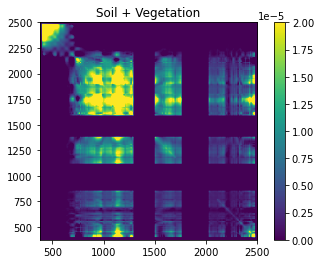

In [76]:
residuals = np.array(residuals)
res_cov = residuals[:,:425].copy()
bands = list(range(0,425))
bands = np.array(bands)
deeph2o = np.logical_or(np.logical_and(bands > 181, bands < 224), np.logical_and(bands > 275, bands < 329))
bad_cal = np.logical_or(bands < 4, bands > 418)
bad = np.logical_or(deeph2o, bad_cal)
res_cov[:, bad] = 0

Cov = np.cov(res_cov, rowvar=False)

plt.imshow(Cov, extent = [375, 2500, 375, 2500])
plt.colorbar()
plt.clim(0,0.00002)
plt.title('Soil + Vegetation')

Text(0.5, 1.0, 'Soil + Vegetation')

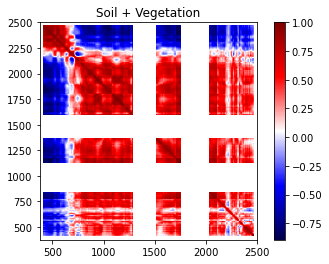

In [74]:
res_cov[:,bad] = 0
corr = np.corrcoef(res_cov, rowvar=False)

plt.imshow(corr, extent = [375, 2500, 375, 2500], cmap = 'seismic')
plt.colorbar()
plt.title('Soil + Vegetation')

In [36]:
len(residuals)

500

In [37]:
residuals = np.array(residuals)
res_h2o = residuals[:,426].copy()
res_aot = residuals[:,425].copy()

Text(0, 0.5, 'Residual')

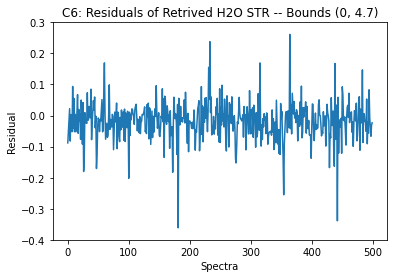

In [50]:
spectra = range(0,500)
plt.plot(spectra, res_h2o, linewidth = 1.5)
plt.ylim(-0.4, 0.3)
plt.title('C6: Residuals of Retrived H2O STR -- Bounds (0, 4.7)')
plt.xlabel('Spectra')
plt.ylabel('Residual')

Text(0, 0.5, 'Residual')

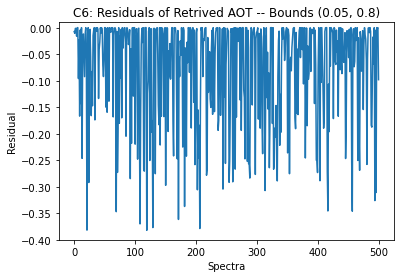

In [51]:
spectra = range(0,500)
plt.plot(spectra, res_aot, linewidth = 1.5)
plt.ylim(-0.4, 0.01)
plt.title('C6: Residuals of Retrived AOT -- Bounds (0.05, 0.8)')
plt.xlabel('Spectra')
plt.ylabel('Residual')

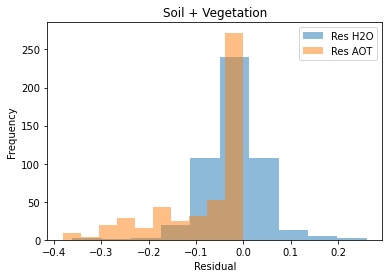

In [75]:
plt.hist(res_h2o, alpha = 0.5, label = 'Res H2O')
plt.hist(res_aot, alpha = 0.5, label = 'Res AOT')
plt.legend(loc='upper right')
plt.ylabel('Frequency')
plt.xlabel('Residual')
plt.title('Soil + Vegetation')
plt.show()
